In [ ]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import os
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# use CUDA processors if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# prepare directories and load feature data
main_dir = '/content/drive/MyDrive/superresolution/nonlinear_classification'
#exp_data = loadmat(f'{main_dir}/Sep27_exp_40mm_SNR10_S5_cp_10d_40m_first200i_digit400_dx10.4_woNorm_shuffle_0.0corr.mat')
sim_data = loadmat(f'{main_dir}/sim_40mm_10d_40m_first200i_digit800_dx5.2_woNorm_noise_20dB_s10_baseline_shuffle.mat')

In [ ]:
# prepare list of image paths in correct order
image_paths = []
for i in range(10): 
  for j in range(1, 201): 
    image_dir = f'{main_dir}/digit_image/{str(i)}'
    path = f'{image_dir}/image{str(j + (((i + 9) % 10) * 1000))}.png'
    image_paths.append(path)
print(*image_paths[:10], '.\n.\n.', *image_paths[-10:], sep='\n')
image_paths = [image_paths[i] for i in sim_data['random_order'][0]]
print("-----------------------------------------------------\nrandomized:", *image_paths[:10], sep='\n')

/content/drive/MyDrive/superresolution/nonlinear_classification/digit_image/0/image9001.png
/content/drive/MyDrive/superresolution/nonlinear_classification/digit_image/0/image9002.png
/content/drive/MyDrive/superresolution/nonlinear_classification/digit_image/0/image9003.png
/content/drive/MyDrive/superresolution/nonlinear_classification/digit_image/0/image9004.png
/content/drive/MyDrive/superresolution/nonlinear_classification/digit_image/0/image9005.png
/content/drive/MyDrive/superresolution/nonlinear_classification/digit_image/0/image9006.png
/content/drive/MyDrive/superresolution/nonlinear_classification/digit_image/0/image9007.png
/content/drive/MyDrive/superresolution/nonlinear_classification/digit_image/0/image9008.png
/content/drive/MyDrive/superresolution/nonlinear_classification/digit_image/0/image9009.png
/content/drive/MyDrive/superresolution/nonlinear_classification/digit_image/0/image9010.png
.
.
.
/content/drive/MyDrive/superresolution/nonlinear_classification/digit_imag

In [ ]:
# load features into tensor form and normalize
raw_data = torch.tensor(sim_data['all_cp'].astype(np.float32)).cuda()
print(raw_data.min(), raw_data.mean(), raw_data.max())
print(raw_data.shape)
print(type(raw_data[0]))

tensor(100000., device='cuda:0') tensor(2.0852e+09, device='cuda:0') tensor(3.2376e+10, device='cuda:0')
torch.Size([2000, 40])
<class 'torch.Tensor'>


In [ ]:
# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(raw_data, image_paths, test_size=200)

In [ ]:
# define data transformations

def feature_transform(x: torch.Tensor):
  # standardizes the features of a given data point
  mean = x.mean()
  std = x.std()
  return x.sub(mean).div(std)

def label_transform_test(y: str):
  # transforms an image path to a usable tensor
  img = Image.open(y)
  convert_tensor = transforms.ToTensor()
  return convert_tensor(img)[0].cuda()

def label_transform_train(y: str):
  # transforms an image path to a usable tensor, with extreme pixels
  img = Image.open(y)
  convert_tensor = transforms.ToTensor()
  label = convert_tensor(img)[0]
  scaled = label.sub(0.5).mul(2)
  extreme = np.cbrt(scaled)
  new = extreme.div(2).add(0.5).cuda()
  return new

In [ ]:
# create train and test Datasets and DataLoaders
class ReconstructionData(Dataset):
  def __init__(self, raw_features: torch.Tensor, image_paths: list, feature_transform, label_transform: None):
    self.features = raw_features
    self.labels = image_paths
    self.feature_transform = feature_transform
    self.label_transform = label_transform


  def __len__(self):
    return len(self.features)
  
  def __getitem__(self, idx):
    data = self.feature_transform(self.features[idx])
    label = self.label_transform(self.labels[idx])
    return data, label

batch_size = 50

train_data = ReconstructionData(X_train, y_train, feature_transform, label_transform_train)
test_data = ReconstructionData(X_test, y_test, feature_transform, label_transform_test)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# show example of modified training label
features, img_tensor = train_data[0]
transform = transforms.ToPILImage()
sample_img = transform(img_tensor)
display(sample_img)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(40, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, 28*28),
            nn.Sigmoid()
        )
        self.unflatten = nn.Unflatten(1, (28, 28))

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        logits = self.unflatten(logits)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=40, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=True)
    (5): Sigmoid()
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(28, 28))
)


In [ ]:
# Training loop

learning_rate = 1e-3
epochs = 192
loss_fn = nn.MSELoss()
"""MAE loss doesnt work because it is prone to produce completely black images as a local minimum loss.
MSE is better because the errors are much more significant."""
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer, print_loss,losses):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if print_loss:
        train_loss /= num_batches
        losses.append(train_loss)
        print(f"Avg batch loss: {train_loss:>8f}")

    return losses

def test_loop(dataloader, model, loss_fn):
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):       
            print(f"batch: {batch+1}")     
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[None, 0]
            orig_img = transform(orig_data)
            pred_data = pred[None, 0]
            pred_img = transform(pred_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print()

    test_loss /= num_batches
    print(f"Avg batch loss: {test_loss:>8f} \n")

In [ ]:
losses = []
for t in range(epochs):
    print_loss = False
    if (t % 16 == 15):
      print_loss = True
      print("-------------------------------")
      print(f"Epoch {t+1}")
    losses = train_loop(train_dataloader, model, loss_fn, optimizer, print_loss, losses)
print("Done!")

-------------------------------
Epoch 16
Avg batch loss: 0.042048
-------------------------------
Epoch 32
Avg batch loss: 0.040523
-------------------------------
Epoch 48
Avg batch loss: 0.039327
-------------------------------
Epoch 64
Avg batch loss: 0.038142
-------------------------------
Epoch 80
Avg batch loss: 0.037128
-------------------------------
Epoch 96
Avg batch loss: 0.036096
-------------------------------
Epoch 112
Avg batch loss: 0.035198
-------------------------------
Epoch 128
Avg batch loss: 0.034530
-------------------------------
Epoch 144
Avg batch loss: 0.033224
-------------------------------
Epoch 160
Avg batch loss: 0.032598
-------------------------------
Epoch 176
Avg batch loss: 0.031828
-------------------------------
Epoch 192
Avg batch loss: 0.030687
Done!


<class 'numpy.ndarray'>


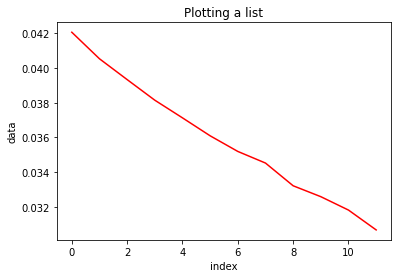

In [ ]:
losses = np.array(torch.tensor(losses).cpu())
print(type(losses))
plt.plot(losses, color='red')
plt.ylabel('data') #set the label for y axis
plt.xlabel('index') #set the label for x-axis
plt.title("Plotting a list") #set the title of the graph
plt.show() #display the graph

In [ ]:
test_loop(test_dataloader, model, loss_fn) 